# Mouse PBMCs from the Mouse Cell Atlas - sample 1

Here we analyse the first sample of PBMCs from the MCA datasets (Microwell-seq Protocol). We downloaded the DGE matrix labelled 'MCA_500more_dge' which contains cells with more than 500 transcripts. The batch genes were not removed.
Link to the dataset: https://figshare.com/articles/MCA_DGE_Data/5435866

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#import preprocessing as scIBpp

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/MCApbmc_1.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [43]:
# Set up data loading
file = '../../../Munich/datasets/mouse/MCA_PBMCs/PeripheralBlood1_dge.txt.gz'
adata = sc.read(filename=file, cache=True)
adata = adata.transpose()

... reading from cache file cache/..-..-..-Munich-datasets-mouse-MCA_PBMCs-PeripheralBlood1_dge.h5ad


In [10]:
adata

AnnData object with n_obs × n_vars = 324 × 14299 

In [11]:
adata.var.head()

""
index
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [44]:
adata.var.index.names = ['gene_symbol']
adata.var.head()

""
gene_symbol
0610007P14Rik
0610009B22Rik
0610009L18Rik
0610009O20Rik
0610010F05Rik


In [24]:
adata.obs.head()

""
index
PeripheralBlood_1.CGCACCAGTTTAGTGGTA
PeripheralBlood_1.GGACATCATCCCATGCTT
PeripheralBlood_1.ACAATAGGTACAGAGATC
PeripheralBlood_1.CTGTGTACCTGAGGTACA
PeripheralBlood_1.TGATCATAGAGAATCTCT


In [45]:
adata.obs.index.names = ['barcodes']
adata.obs.head()

""
barcodes
PeripheralBlood_1.CGCACCAGTTTAGTGGTA
PeripheralBlood_1.GGACATCATCCCATGCTT
PeripheralBlood_1.ACAATAGGTACAGAGATC
PeripheralBlood_1.CTGTGTACCTGAGGTACA
PeripheralBlood_1.TGATCATAGAGAATCTCT


In [46]:
adata.var_names_make_unique()

In [28]:
# Checking the total size of the data set
adata.shape

(324, 14299)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [47]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [48]:
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


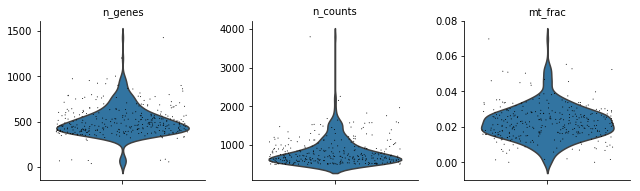

In [33]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

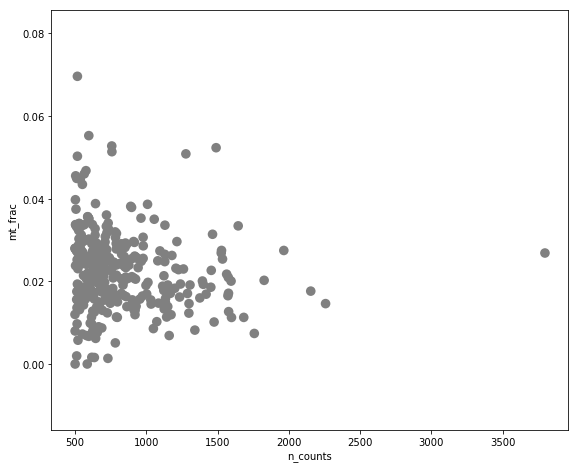

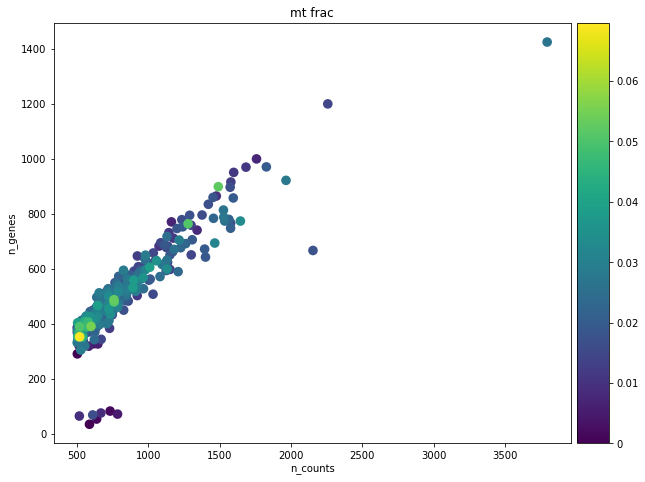

In [35]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

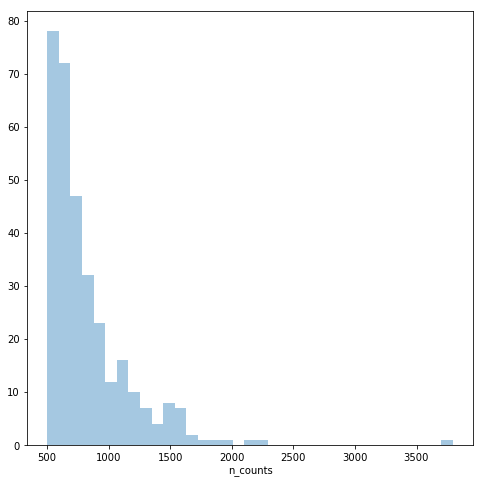

In [37]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

The histogram of the number of counts per cell show that there's a smaller group of cells with n_counts > 2000 which are standing apart from the main population. 

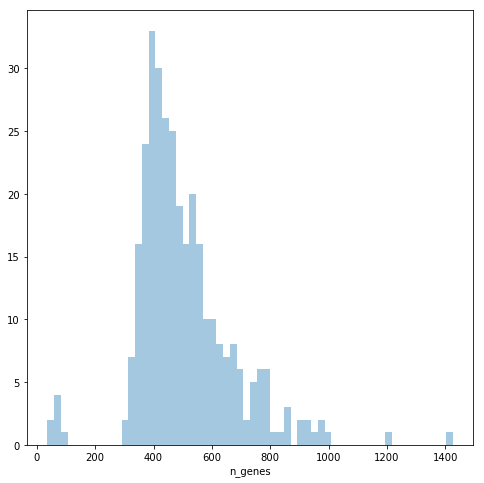

In [38]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

From the histogram of number of genes, we can exclude the small population with n_genes < 200.
No need to threshold on mt_frac.

In [49]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 2000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 324
filtered out 3 cells that havemore than 2000 counts
Number of cells after max count filter: 321
filtered out 7 cells that haveless than 200 genes expressed
Number of cells after gene filter: 314


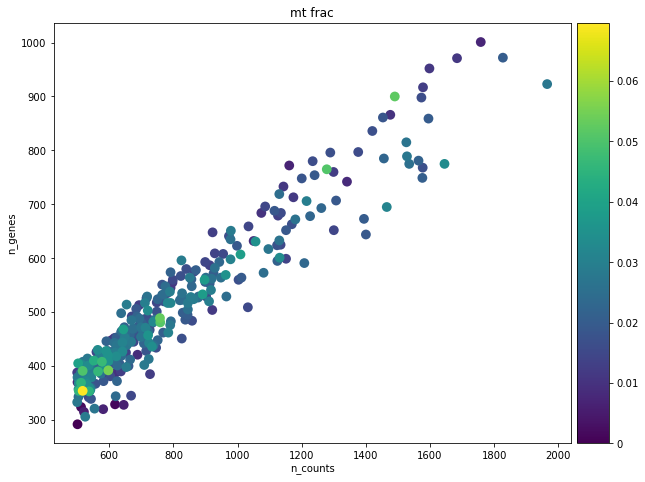

In [40]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

In [50]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 14299
filtered out 8174 genes that are detectedin less than 5 cells
Number of genes after cell filter: 6125


## 1.2 Normalization

In [51]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [52]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    158
1     96
2     44
3     16
Name: groups, dtype: int64

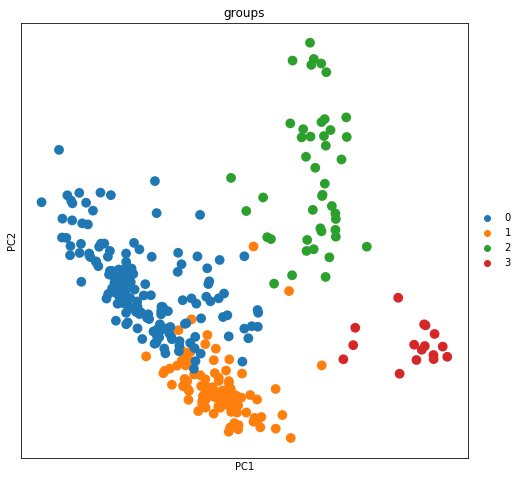

In [53]:
# Check that the smallest cluster (which is < 21) doesn't show any problem
sc.pl.pca_scatter(adata_pp, color='groups')

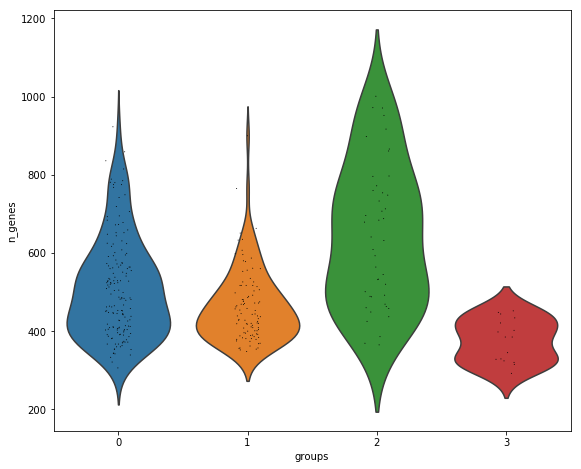

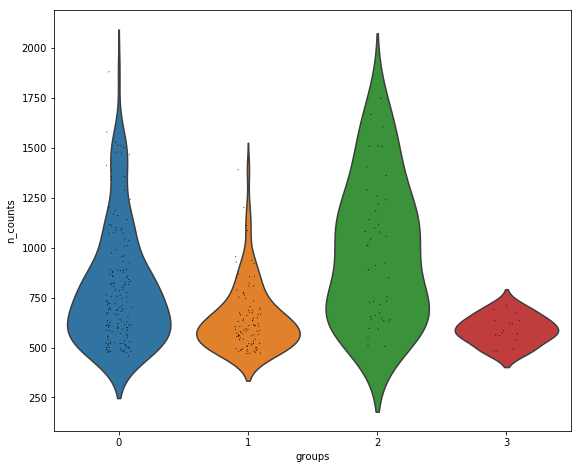

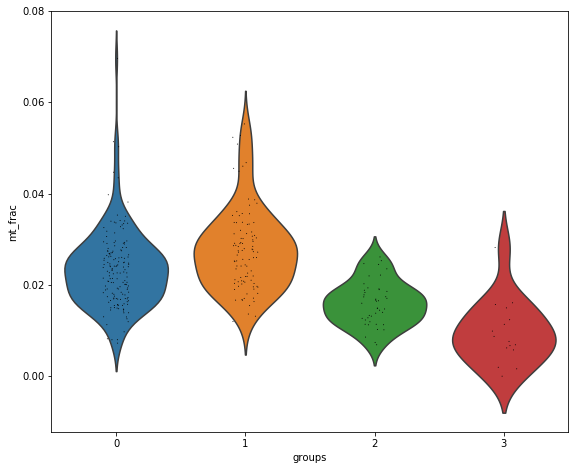

In [54]:
sc.pl.violin(adata_pp, 'n_genes', groupby= 'groups')
sc.pl.violin(adata_pp, 'n_counts', groupby= 'groups')
sc.pl.violin(adata_pp, 'mt_frac', groupby= 'groups')

In [55]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [56]:
# Having the smallest cluster size = 16 we need to pass sizes as input
sizes = input_groups.value_counts()

In [57]:
%%R -i data_mat -i input_groups -i sizes -o size_factors

size_factors = computeSumFactors(data_mat, sizes = sizes, clusters=input_groups, min.mean=0.1)

In [58]:
#Delete adata_pp
del adata_pp

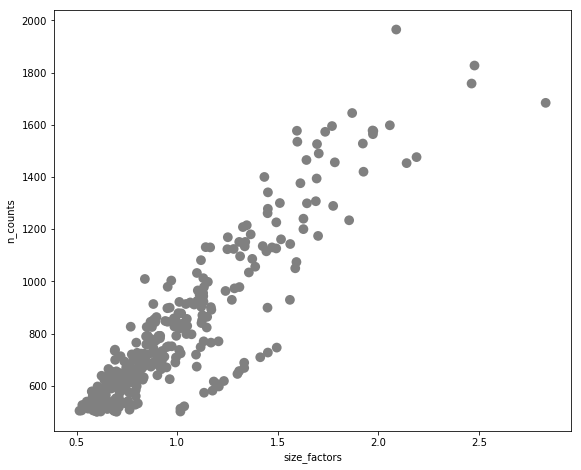

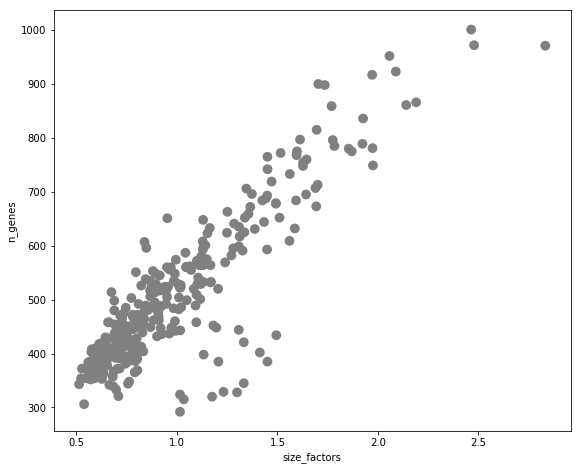

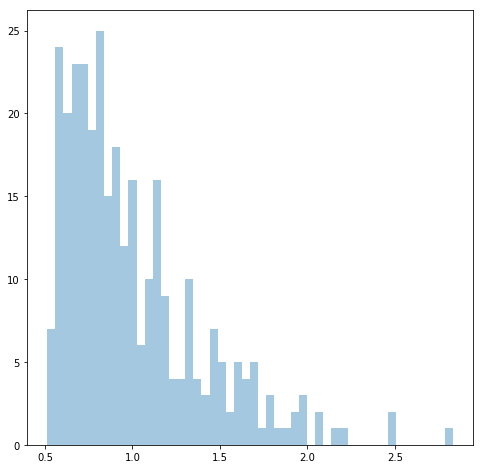

In [59]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [60]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [61]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [62]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [63]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


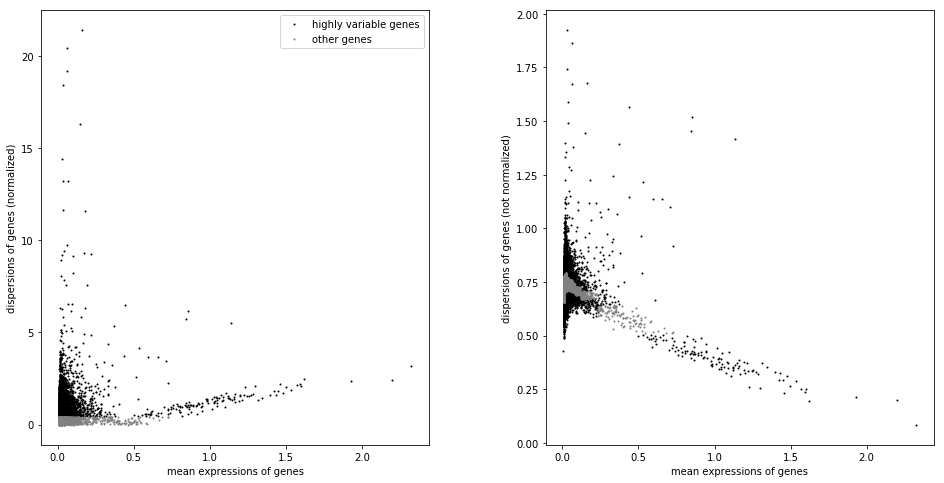

In [64]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [65]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.9771766   0.96703774  0.96056926  0.86833405  0.7079134
      0.6834686   0.63828033  0.6249764   0.61417246  0.607628    0.5771181
      0.57284755  0.5614049  -0.5866573 ]
    finished (0:00:00)
drawing single-cell graph using layout 'fa'
    finished (0:00:02)


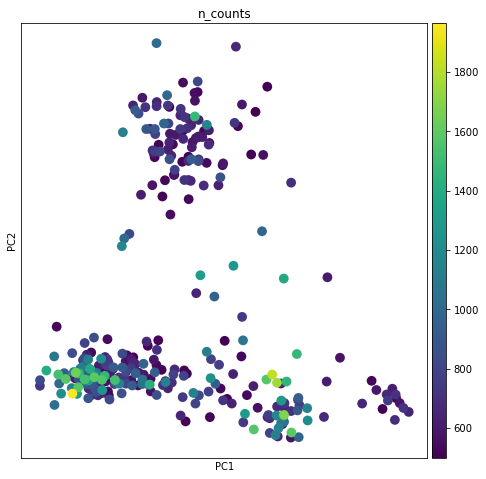

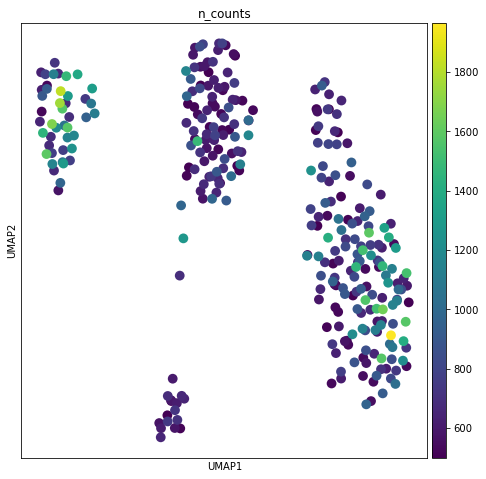

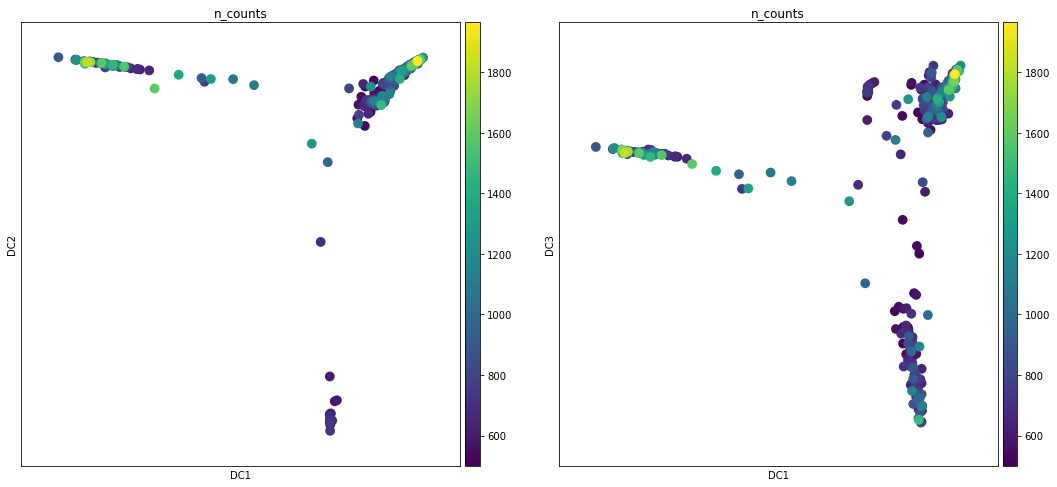

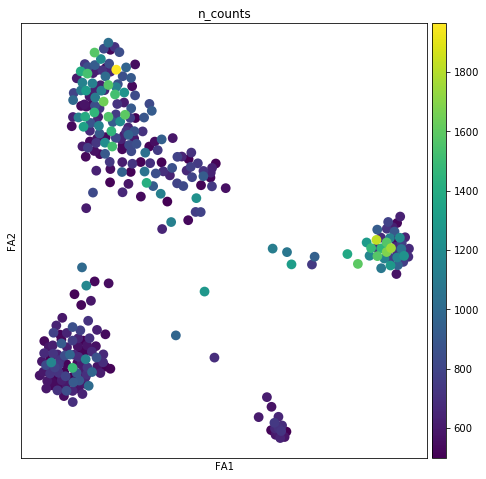

In [66]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [67]:
adata.write(results_file)

# 3. Clustering

In [68]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [69]:
adata.obs['louvain_r0.5'].value_counts()

0    159
1     93
2     45
3     17
Name: louvain_r0.5, dtype: int64

In [70]:
adata.obs['louvain_r1'].value_counts()

0    103
1     93
2     56
3     45
4     17
Name: louvain_r1, dtype: int64

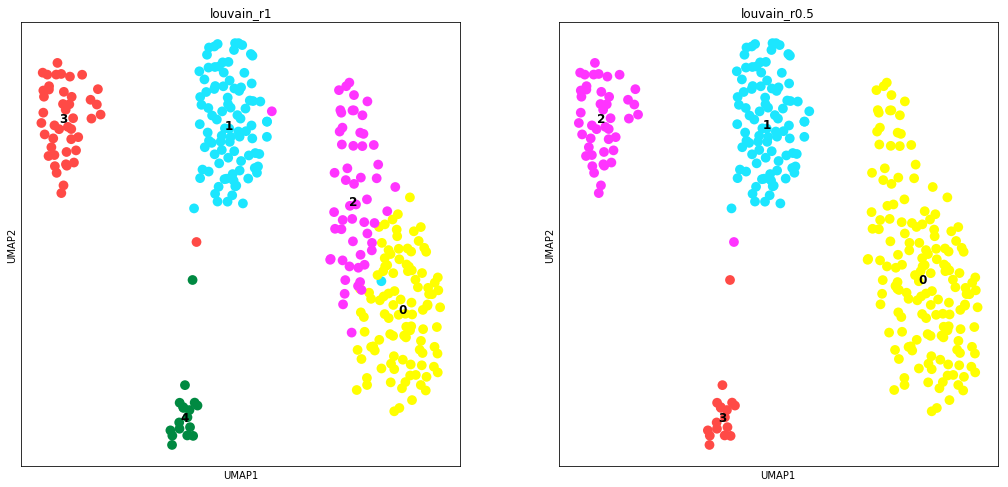

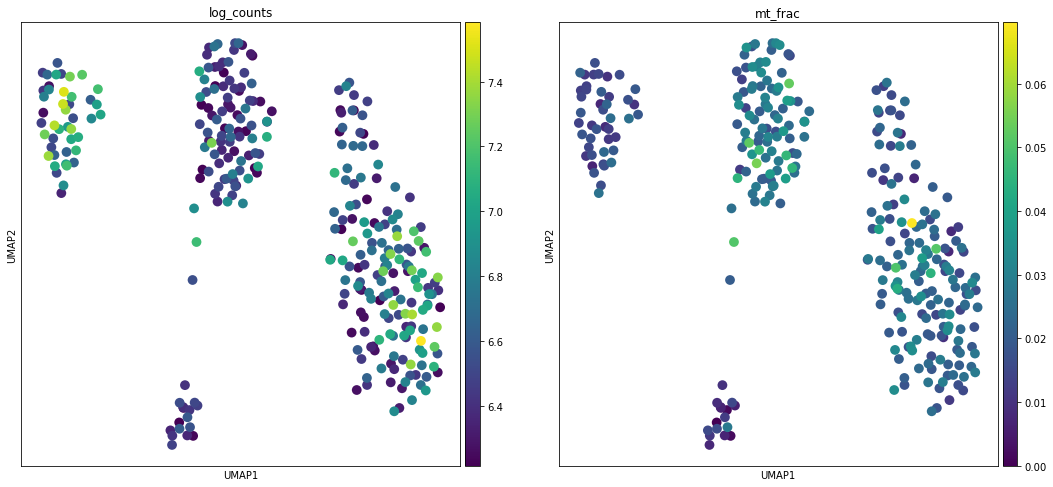

In [71]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 0.5)

## 4.1 Short list of cell types (PanglaoDB)

In [72]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:01)


In [74]:
# Known marker genes taken from PanglaoDB (short list of 12 cell types)
markers_short_df = pd.read_csv('../../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [75]:
markers_short_df.head()

,species,official.gene.symbol,cell.type,nicknames,ubiquitousness.index,product.description,gene.type,canonical.marker,germ.layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
417,Mm Hs,CD2,B cells,NaN,0.040,CD2 molecule,protein-coding gene,NaN,Mesoderm,Immune system,0.000000,0.212355,0.095847,0.026556
418,Mm Hs,CD5,B cells,NaN,0.004,CD5 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.000000,0.000000,0.004153,0.004502
419,Mm Hs,MS4A1,B cells,Bp35|MS4A2|CD20,0.014,membrane spanning 4-domains A1,protein-coding gene,1.0,Mesoderm,Immune system,0.483871,0.617761,0.011182,0.001566
420,Mm Hs,CR2,B cells,CD21|C3DR,0.001,complement C3d receptor 2,protein-coding gene,1.0,Mesoderm,Immune system,0.048387,0.034749,0.000000,0.000000
421,Mm Hs,CD22,B cells,SIGLEC-2|SIGLEC2,0.003,CD22 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.096774,0.127413,0.001278,0.000196


Select only genes that are annotated for mouse:

In [76]:
markers_short_df_mou = markers_short_df[(markers_short_df['species'] == 'Mm') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_mou.shape

(873, 14)

In [78]:
cell_types = list(markers_short_df_mou['cell.type'].unique())

In [79]:
markers_dict = {}

In [112]:
for ctype in cell_types:
    df = markers_short_df_mou[markers_short_df_mou['cell.type'] == ctype]
    genes = df['official.gene.symbol'].to_list()
    markers_dict[ctype] = [item.lower().capitalize() for item in genes]

In [114]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

,0,1,2,3
B cells,0.0,36.0,0.0,1.0
B cells naive,0.0,19.0,0.0,0.0
Dendritic cells,1.0,5.0,12.0,4.0
Erythroid-like and erythroid precursor cells,0.0,1.0,1.0,4.0
Gamma delta T cells,4.0,0.0,0.0,1.0
Monocytes,0.0,0.0,9.0,5.0
NK cells,6.0,0.0,1.0,0.0
Plasmacytoid dendritic cells,1.0,4.0,0.0,1.0
Platelets,0.0,0.0,6.0,7.0
T cells,15.0,1.0,4.0,2.0


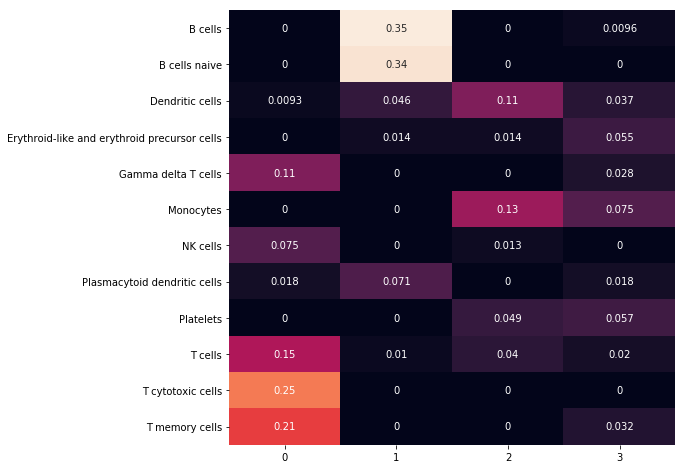

In [115]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

## 4.2 Long list of cell types
Here we try using the long list of cell types (29) from PanglaoDB, considering all cell types in "immune system" + "blood". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [117]:
markers_long_df = pd.read_csv('../../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df.shape

(1866, 14)

In [118]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_long_df.shape

(1849, 14)

In [119]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Red pulp macrophages']
markers_long_df.shape

(1837, 14)

In [120]:
markers_long_df_mou = markers_long_df[(markers_long_df['species'] == 'Mm') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_mou.shape

(1678, 14)

In [121]:
cell_types = list(markers_long_df_mou['cell.type'].unique())

In [122]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_mou[markers_long_df_mou['cell.type'] == ctype]
    genes = df['official.gene.symbol'].to_list()
    markers_dict_long[ctype] = [item.lower().capitalize() for item in genes]

In [123]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

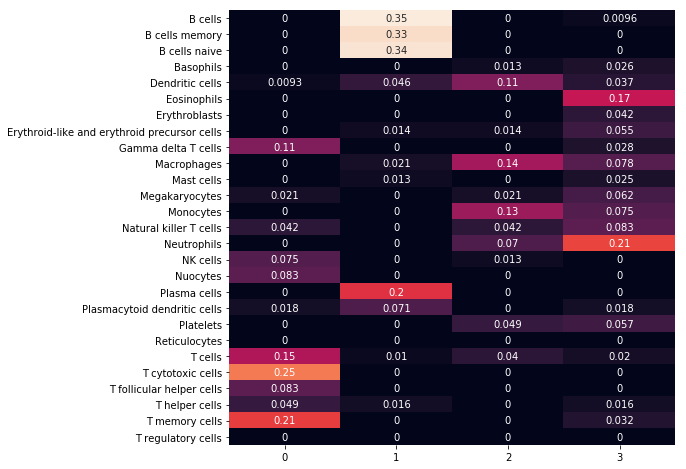

In [124]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

# 5. Markers and cluster annotation (r 1)

In [125]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:00)


# 5.1 Long list of cell types

Here we use only the long list, which showed improvements over the short one.

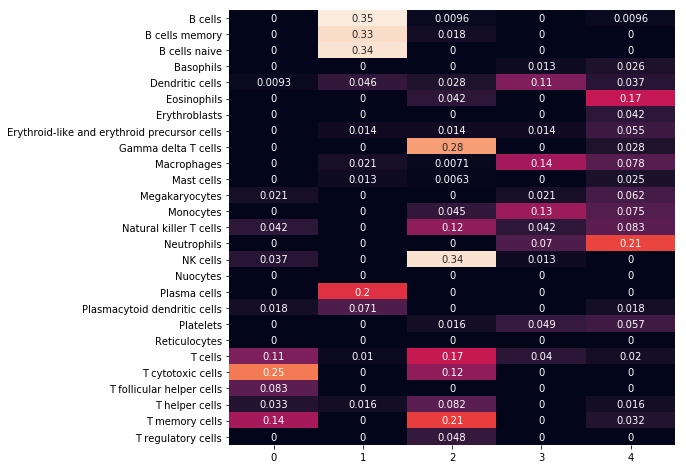

In [126]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

In [127]:
# Categories to rename
adata.obs['cell_type1long'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1long', ['T cytotoxic', 'B cells', 'T mem + NK + gamma delta', 'Monocytes', 'Neutrophils + Eosinophils'])

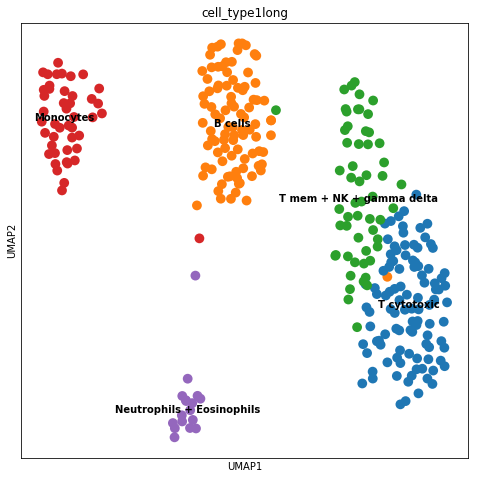

In [128]:
sc.pl.umap(adata, color='cell_type1long', legend_loc='on data')

# 6. Plot makers of subtypes

In [83]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

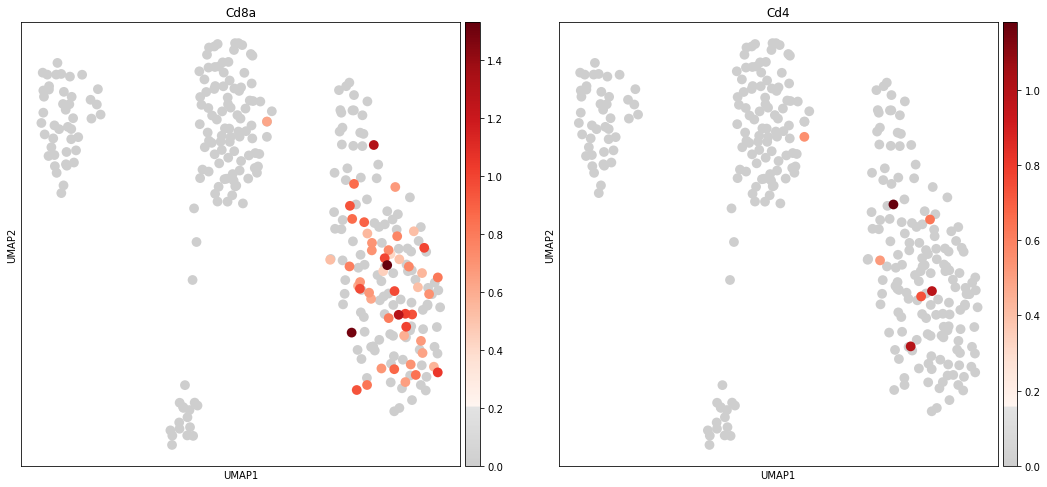

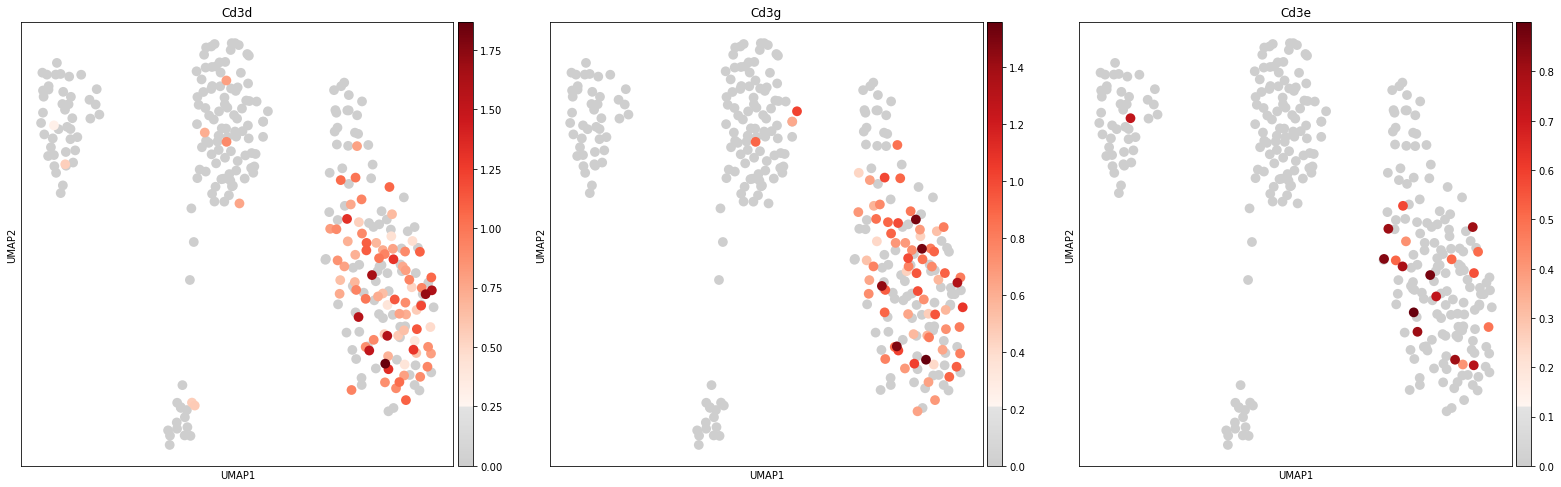

In [87]:
#Canonical markers
sc.pl.umap(adata, color=['Cd8a', 'Cd4'], use_raw=False, color_map=mymap)
sc.pl.umap(adata, color=['Cd3d', 'Cd3g', 'Cd3e'], use_raw=False, color_map=mymap)

Cluster 0 (louvain r1) is CD8+ T cells, there are no (or few) CD4+ T cells.

### Natural killer T cells

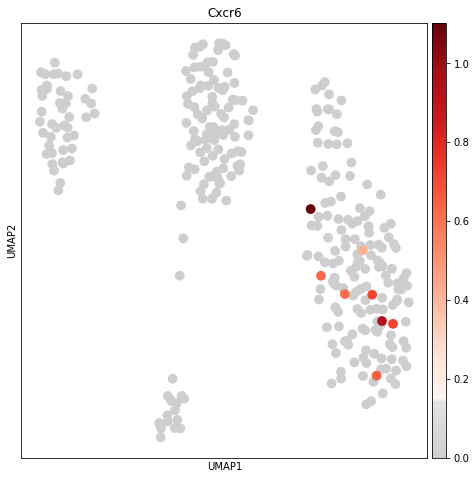

In [89]:
sc.pl.umap(adata, color=['Cxcr6'], use_raw=False, color_map=mymap)

Few cells of cluster 0 and 2 seems to be NKT [Stegmann et al.](https://www.nature.com/articles/srep26157)

### T regulatory cells

In [93]:
#Canonical markers
##sc.pl.umap(adata, color=['Ccr10','Il2ra', 'Foxp3'], use_raw=False, color_map=mymap)


No markers of T reg are present in our data. [Ballke et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4751285/)

### T memory cells

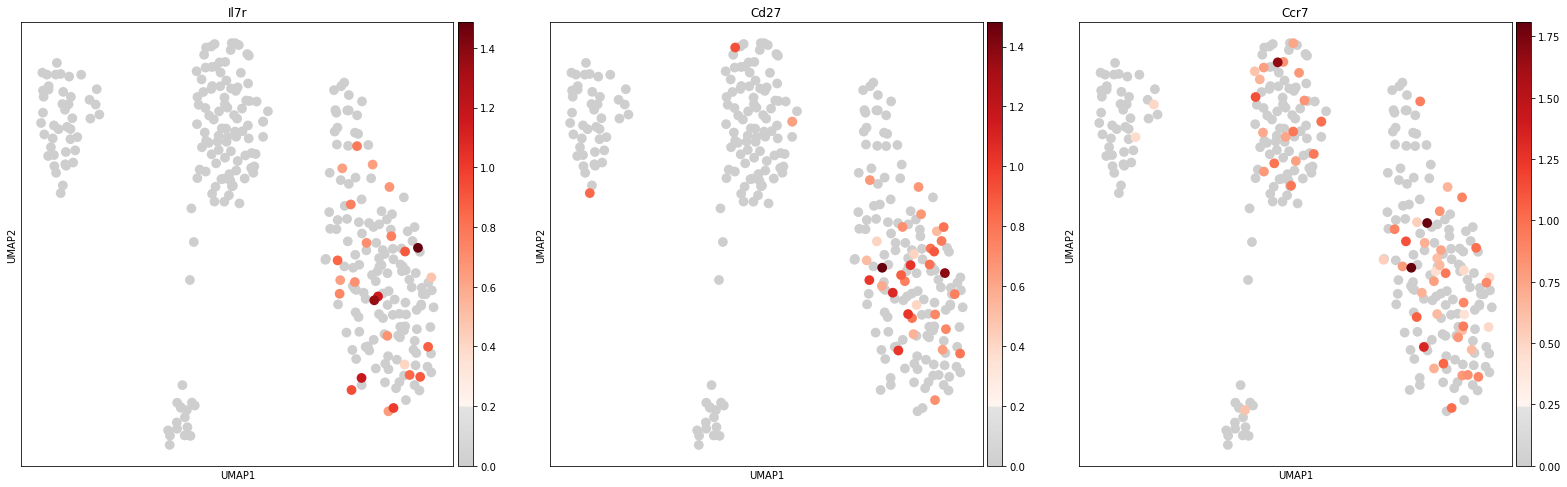

In [94]:
sc.pl.umap(adata, color=['Il7r','Cd27', 'Ccr7'], use_raw=False, color_map=mymap)

Few cells in clusters 0 and 2 are CD8+ T mem. (from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Cytotoxic T cells

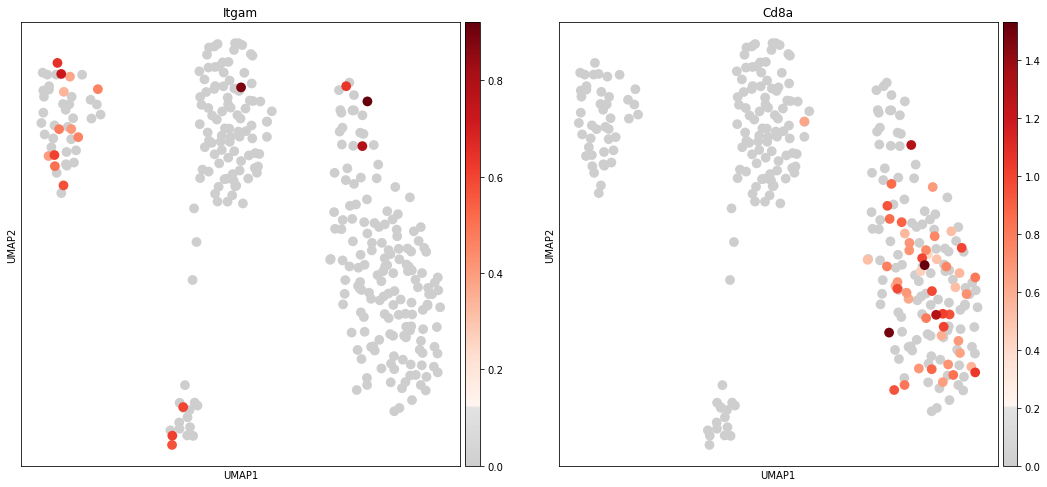

In [95]:
sc.pl.umap(adata, color=['Itgam','Cd8a'], use_raw=False, color_map=mymap)

No Cytotoxic T cells ([CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

## NK cells

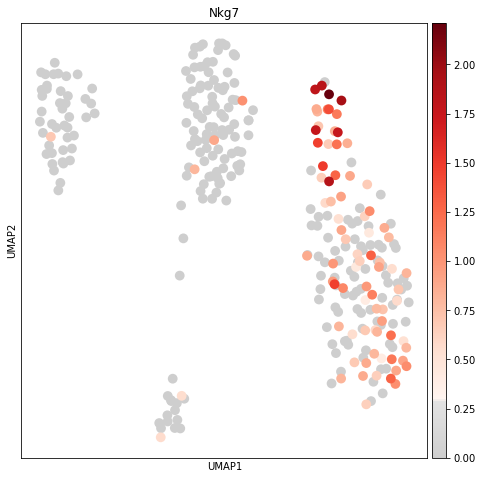

In [98]:
sc.pl.umap(adata, color=['Nkg7'], use_raw=False, color_map=mymap)

Cluster 2 is mainly enriched with NK cells.

## Monocytes: CD14+ and CD16+

Monocytes markers are not present in the data.

In [101]:
##sc.pl.umap(adata, color=['Fcgr3a','Cd14'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

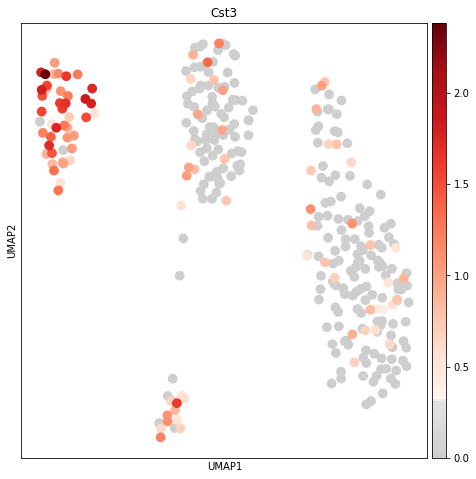

In [104]:
sc.pl.umap(adata, color=['Cst3'], use_raw=False, color_map=mymap)

Cluster 3 is probably monocytes. [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

## B cells

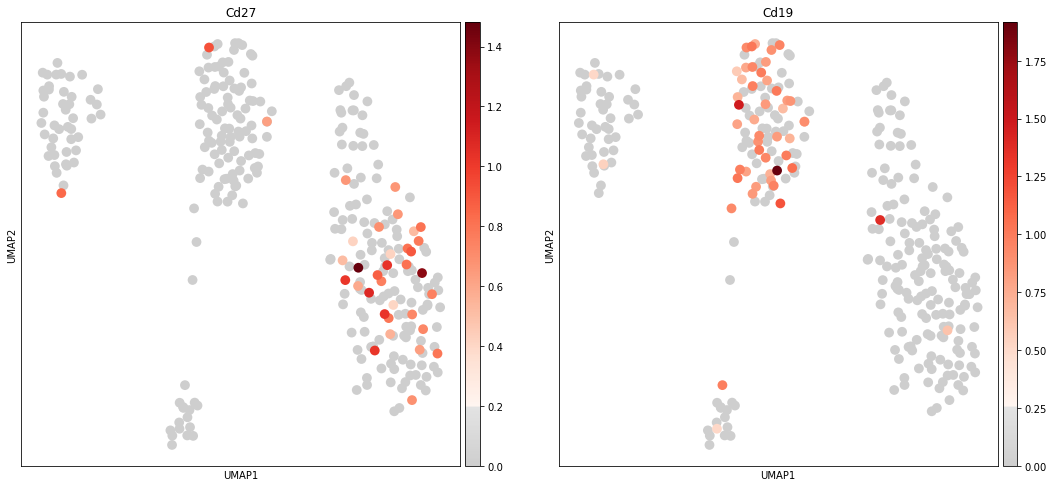

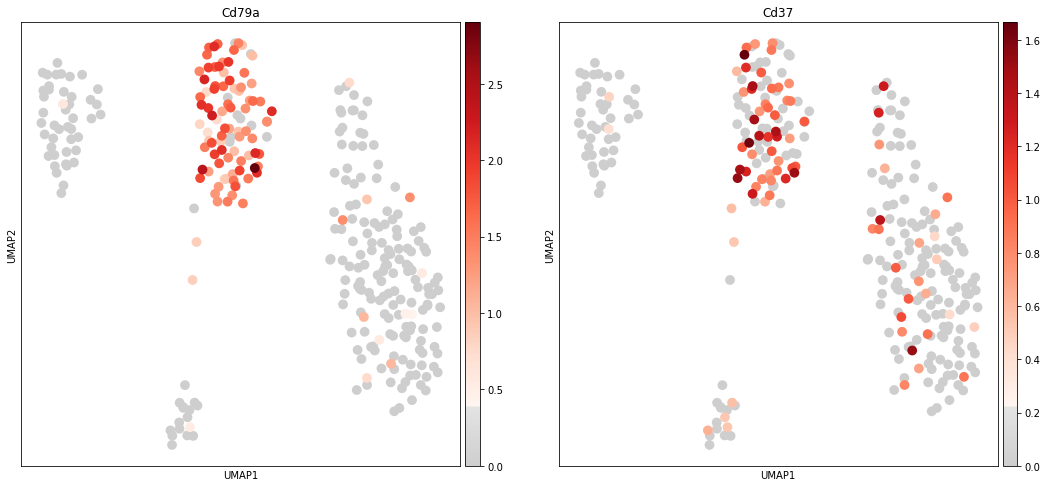

In [105]:
sc.pl.umap(adata, color=['Cd27', 'Cd19'], use_raw=False, color_map=mymap)
sc.pl.umap(adata, color=['Cd79a', 'Cd37'], use_raw=False, color_map=mymap)

Cluter 1 is B cells. First 2 markers are from CellMarker, second 2 from Sinha et al.

# 7. Final cell-type annotation

In [130]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1']
adata.rename_categories('final_annotation', ['CD8+ T cells', 'B cells', 'NK cells', 'Monocytes', 'Neutrophils + Eosinophils'])

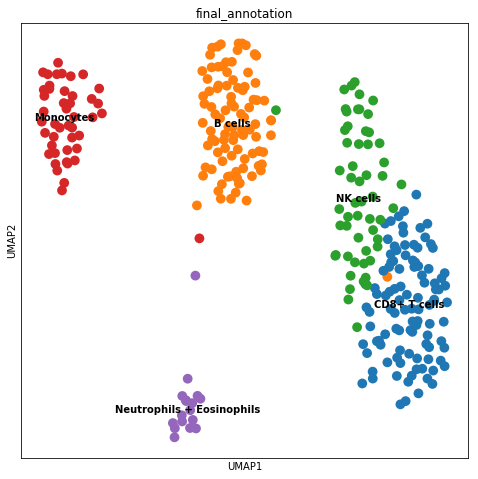

In [131]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [132]:
# save final result
adata.write(results_file)